In [ ]:
# Устанавливаем необходимые пакеты
!pip install gdown
!apt-get install unrar

# Скачиваем тренировочный датасет
!gdown https://drive.google.com/uc?id=1EvRvxa_E3Td2lQdkq490LQA1frQh1IBs -O train.rar

# Скачиваем валидационный датасет
!gdown https://drive.google.com/uc?id=1jq2K_TAcINN9cdsxlA9MP4-hpzTS7xN6 -O val.rar

# Создаем папки для распаковки
!mkdir -p train && mkdir -p val

# Извлекаем архивы в соответствующие папки
!unrar x train.rar train/
!unrar x val.rar val/


Выходные данные были обрезаны до нескольких последних строк (5000).
Extracting  train/train/FRONTAL/11662_frontal.png                          5%  OK 
Extracting  train/train/FRONTAL/11448_frontal.png                          5%  OK 
Extracting  train/train/FRONTAL/10863_frontal.png                          5%  OK 
Extracting  train/train/FRONTAL/10299_frontal.png                          5%  OK 
Extracting  train/train/FRONTAL/11202_frontal.png                          5%  OK 
Extracting  train/train/FRONTAL/11517_frontal.png                          5%  OK 
Extracting  train/train/FRONTAL/11652_frontal.png                          5%  OK 
Extracting  train/train/FRONTAL/10213_frontal.png                          5%  OK 
Extracting  train/train/FRONTAL/11122_frontal.png                          5%  OK 
Extracting  train/train/FRONTAL/102332.png                                 6%  OK 
Extracting  

Обрабатываем папку: /content/train/train
  Найдена поддиректория: LATERAL
    Файл: 12627_lateral.png
    Файл: 10987_lateral.png
    Файл: 12849_lateral.png
    Файл: 12425_lateral.png
    Файл: 11283_lateral.png
    Файл: 12245_lateral.png
    Файл: 11849_lateral.png
    Файл: 12059_lateral.png
    Файл: 11364_lateral.png
    Файл: 10591_lateral.png
    Файл: 10693_lateral.png
    Файл: 11426_lateral.png
    Файл: 11998_lateral.png
    Файл: 11510_lateral.png
    Файл: 10597_lateral.png
    Файл: 12512_lateral.png
    Файл: 11680_lateral.png
    Файл: 10649_lateral.png
    Файл: 12612_lateral.png
    Файл: 11856_lateral.png
    Файл: 10509_lateral.png
    Файл: 11880_lateral.png
    Файл: 11807_lateral.png
    Файл: 12036_lateral.png
    Файл: 11584_lateral.png
    Файл: 10748_lateral.png
    Файл: 12405_lateral.png
    Файл: 12306_lateral.png
    Файл: 11873_lateral.png
    Файл: 10703_lateral.png
    Файл: 12544_lateral.png
    Файл: 10685_lateral.png
    Файл: 11696_lateral.png
  

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 174MB/s]


Epoch 1/10 | Train Loss: 0.1105 | Train Acc: 0.9598 | Val Acc: 0.9296
Saved best weights.
Epoch 2/10 | Train Loss: 0.0601 | Train Acc: 0.9776 | Val Acc: 0.8975
Epoch 3/10 | Train Loss: 0.0427 | Train Acc: 0.9846 | Val Acc: 0.8935
Epoch 4/10 | Train Loss: 0.0395 | Train Acc: 0.9884 | Val Acc: 0.8985
Epoch 5/10 | Train Loss: 0.0369 | Train Acc: 0.9884 | Val Acc: 0.8985
Epoch 6/10 | Train Loss: 0.0312 | Train Acc: 0.9899 | Val Acc: 0.8975
Epoch 7/10 | Train Loss: 0.0390 | Train Acc: 0.9867 | Val Acc: 0.8975
Epoch 8/10 | Train Loss: 0.0344 | Train Acc: 0.9894 | Val Acc: 0.8975
Epoch 9/10 | Train Loss: 0.0232 | Train Acc: 0.9911 | Val Acc: 0.9005
Epoch 10/10 | Train Loss: 0.0319 | Train Acc: 0.9906 | Val Acc: 0.8975
Classification Report:
              precision    recall  f1-score   support

     frontal       1.00      0.69      0.82       326
     lateral       1.00      1.00      1.00       329
       trash       0.77      1.00      0.87       340

    accuracy                          

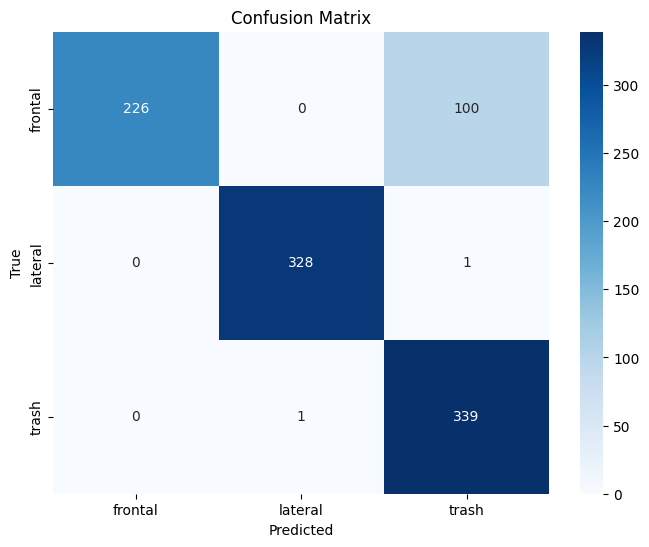

CSV файл с результатами сохранен как results.csv


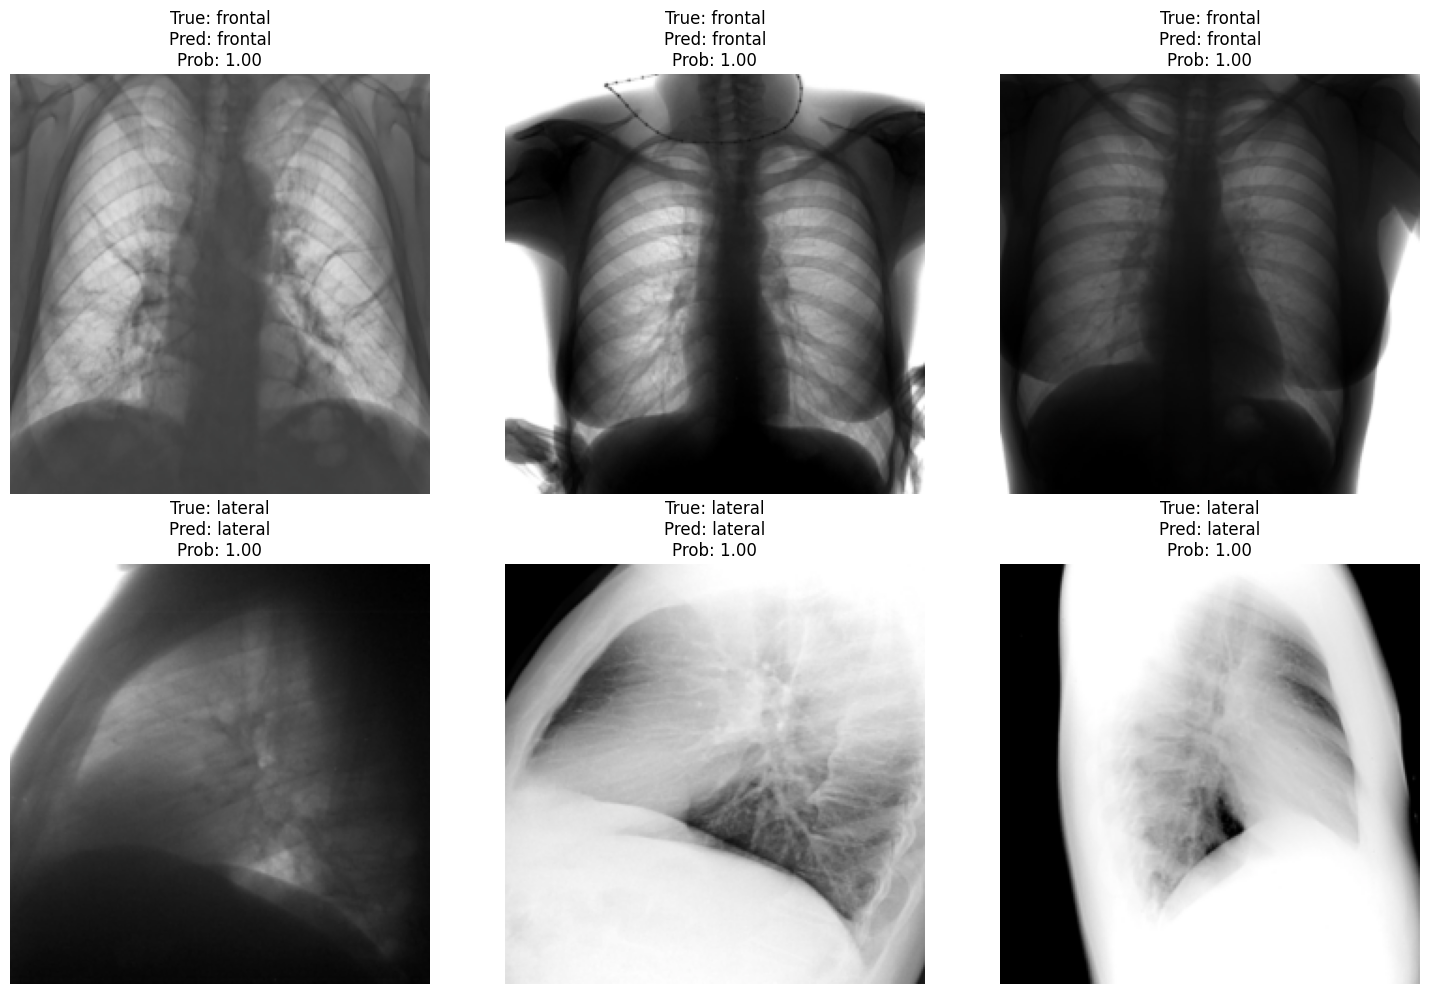

In [ ]:
import os
import csv
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Обновлённые пути к датасетам (после распаковки)
TRAIN_DIR = '/content/train/train'       # ожидается структура: train/FRONTAL, train/LATERAL, train/TRASH
VAL_DIR   = '/content/val/validation'      # ожидается структура: validation/FRONTAL, validation/LATERAL, validation/TRASH

# Функция для загрузки списка файлов и меток по папкам
def load_dataset(folder):
    image_paths = []
    labels = []
    # Словарь классов, ключи указаны в нижнем регистре
    class_map = {'frontal': 0, 'lateral': 1, 'trash': 2}
    print("Обрабатываем папку:", folder)
    for class_name in os.listdir(folder):
        class_folder = os.path.join(folder, class_name)
        if os.path.isdir(class_folder):
            print(f"  Найдена поддиректория: {class_name}")
            for fname in os.listdir(class_folder):
                if fname.lower().endswith('.png'):
                    image_paths.append(os.path.join(class_folder, fname))
                    # Приводим имя папки к нижнему регистру для корректного поиска в словаре
                    labels.append(class_map[class_name.lower()])
                    print(f"    Файл: {fname}")
    return image_paths, labels

# Определяем Dataset для чтения изображений
class XRayDataset(Dataset):
    def __init__(self, image_paths, labels=None, transform=None):
        self.image_paths = image_paths
        self.labels = labels  # Если labels=None, используется для инференса
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        # Возвращаем также базовое имя файла
        if self.labels is not None:
            label = self.labels[idx]
            return img, label, os.path.basename(self.image_paths[idx])
        else:
            return img, os.path.basename(self.image_paths[idx])

# Преобразования для обучения и валидации
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Загрузка путей и меток
train_images, train_labels = load_dataset(TRAIN_DIR)
val_images, val_labels = load_dataset(VAL_DIR)
print("Найдено изображений в train:", len(train_images))
print("Найдено изображений в validation:", len(val_images))

# Создаём объекты датасетов
train_dataset = XRayDataset(train_images, train_labels, transform=train_transform)
val_dataset = XRayDataset(val_images, val_labels, transform=val_transform)

# Создаем DataLoader'ы
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# Загружаем предварительно обученную модель ResNet18 и модифицируем последний слой
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 3)  # 3 класса: frontal, lateral, trash
model = model.to(device)

# Задаем функцию потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-4)

# Функция обучения модели
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels, _ in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)

        # Валидация
        model.eval()
        val_corrects = 0
        with torch.no_grad():
            for inputs, labels, _ in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)
        val_acc = val_corrects.double() / len(val_dataset)

        print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | Val Acc: {val_acc:.4f}')

        # Сохраняем лучшие веса
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model_weights.pth')
            print("Saved best weights.")
    return model

# Обучение модели (количество эпох можно увеличить)
model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

# Сохраняем финальные веса модели (если требуется)
torch.save(model.state_dict(), 'final_model_weights.pth')

# Функция инференса на датасете Validation (возвращает предсказания и истинные метки)
def inference(model, dataset):
    model.eval()
    image_ids = []
    preds_activation = []
    all_preds = []
    all_labels = []  # для вычисления метрик
    softmax = nn.Softmax(dim=1)

    infer_loader = DataLoader(dataset, batch_size=32, shuffle=False)
    with torch.no_grad():
        for data in infer_loader:
            # Если имеются метки (длина data == 3)
            if len(data) == 3:
                inputs, labels, names = data
                all_labels.extend(labels.numpy())
            else:
                inputs, names = data
            inputs = inputs.to(device)
            outputs = model(inputs)
            probabilities = softmax(outputs)
            probabilities_np = probabilities.cpu().numpy()
            preds = np.argmax(probabilities_np, axis=1)
            image_ids.extend(names)
            preds_activation.extend(probabilities_np.tolist())
            all_preds.extend(preds.tolist())
    return image_ids, preds_activation, all_preds, all_labels

image_ids, activations, predictions, true_labels = inference(model, val_dataset)

# Вычисляем метрики классификации (если имеются истинные метки)
print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=['frontal', 'lateral', 'trash']))

# Строим confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
            xticklabels=['frontal', 'lateral', 'trash'],
            yticklabels=['frontal', 'lateral', 'trash'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Формируем DataFrame и сохраняем CSV с результатами инференса
results = []
for img_id, act in zip(image_ids, activations):
    results.append([img_id] + act)

df = pd.DataFrame(results, columns=['image_id', 'frontal', 'lateral', 'trash'])
df.to_csv('results.csv', index=False)
print("CSV файл с результатами сохранен как results.csv")

# Визуализация предсказаний
def visualize_predictions(model, dataset, class_names=['frontal', 'lateral', 'trash'], num_images=6):
    model.eval()
    # Выбираем случайные изображения из датасета
    indices = np.random.choice(len(dataset), num_images, replace=False)
    plt.figure(figsize=(15, 10))

    for i, idx in enumerate(indices):
        # Получаем изображение, истинную метку и имя файла
        img, label, img_name = dataset[idx]
        # Прогон изображения через модель
        input_img = img.unsqueeze(0).to(device)
        output = model(input_img)
        prob = nn.Softmax(dim=1)(output)
        prob_np = prob.cpu().detach().numpy()[0]
        pred_label = np.argmax(prob_np)

        # Визуализируем изображение с предсказаниями
        plt.subplot(2, (num_images+1)//2, i+1)
        # Обратное нормирование для корректного отображения
        img_disp = img.clone().cpu()
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
        img_disp = img_disp * std + mean
        img_disp = np.clip(img_disp.numpy().transpose(1,2,0), 0, 1)

        plt.imshow(img_disp)
        plt.axis('off')
        title = f"True: {class_names[label]}\nPred: {class_names[pred_label]}\nProb: {prob_np[pred_label]:.2f}"
        plt.title(title)
    plt.tight_layout()
    plt.show()

# Визуализируем несколько предсказаний на валидационном наборе
visualize_predictions(model, val_dataset)
